In [105]:
import math
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

import nltk
from nltk import bigrams, trigrams
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from spellchecker import SpellChecker


import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV

from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor

from sklearn.tree import DecisionTreeRegressor

from sklearn.multioutput import MultiOutputRegressor

In [63]:
ptrain = pd.read_csv("../data/prompts_train.csv")
ptest = pd.read_csv("../data/prompts_test.csv")
strain = pd.read_csv("../data/summaries_train.csv")
stest = pd.read_csv("../data/summaries_test.csv")
ss = pd.read_csv("../data/sample_submission.csv")

In [64]:
ptrain.head()

,prompt_id,prompt_question,prompt_title,prompt_text
0,39c16e,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \r\nAs the sequel to what has alrea...
1,3b9047,"In complete sentences, summarize the structure...",Egyptian Social Structure,Egyptian society was structured like a pyramid...
2,814d6b,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...
3,ebad26,Summarize the various ways the factory would u...,Excerpt from The Jungle,"With one member trimming beef in a cannery, an..."


In [65]:
strain.head()

,student_id,prompt_id,text,content,wording
0,000e8c3c7ddb,814d6b,The third wave was an experimentto see how peo...,0.205683,0.380538
1,0020ae56ffbf,ebad26,They would rub it up with soda to make the sme...,-0.548304,0.506755
2,004e978e639e,3b9047,"In Egypt, there were many occupations and soci...",3.128928,4.231226
3,005ab0199905,3b9047,The highest class was Pharaohs these people we...,-0.210614,-0.471415
4,0070c9e7af47,814d6b,The Third Wave developed rapidly because the ...,3.272894,3.219757


In [66]:
# Merge summaries and prompt based on prompt_id
train_merged = pd.merge(ptrain, strain, on = 'prompt_id', how = "inner")

In [67]:
train_merged.head()

,prompt_id,prompt_question,prompt_title,prompt_text,student_id,text,content,wording
0,39c16e,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \r\nAs the sequel to what has alrea...,00791789cc1f,1 element of an ideal tragedy is that it shoul...,-0.210614,-0.471415
1,39c16e,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \r\nAs the sequel to what has alrea...,0086ef22de8f,The three elements of an ideal tragedy are: H...,-0.970237,-0.417058
2,39c16e,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \r\nAs the sequel to what has alrea...,0094589c7a22,Aristotle states that an ideal tragedy should ...,-0.387791,-0.584181
3,39c16e,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \r\nAs the sequel to what has alrea...,00cd5736026a,One element of an Ideal tragedy is having a co...,0.088882,-0.594710
4,39c16e,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \r\nAs the sequel to what has alrea...,00d98b8ff756,The 3 ideal of tragedy is how complex you need...,-0.687288,-0.460886


In [68]:
train_merged.shape

(7165, 8)

In [69]:
#checking null values
train_merged.isna().sum()

prompt_id          0
prompt_question    0
prompt_title       0
prompt_text        0
student_id         0
text               0
content            0
wording            0
dtype: int64

In [70]:
train_merged['prompt_id'].value_counts()

39c16e    2057
3b9047    2009
ebad26    1996
814d6b    1103
Name: prompt_id, dtype: int64

Here we notice that there are only 4 prompts, which means that the prompt question are only 4 and students have written summaries of the prompt_text. I can think of 2 ways of approaching this:-
1. Split the dataset into 4 prompt questions. Train a machine learning model on all 4 of them individually.
2. Keep the dataset as is, and encode the prompt_id as 0,1,2,3

# Approach 1

In [71]:
df_1 = train_merged.loc[train_merged['prompt_id'] == '39c16e']
df_2 = train_merged.loc[train_merged['prompt_id'] == '3b9047']
df_3 = train_merged.loc[train_merged['prompt_id'] == 'ebad26']
df_4 = train_merged.loc[train_merged['prompt_id'] == '814d6b']

### Features:-
1. Length of the text
2. TTR of text
3. Ratio of stopwords to the length of the text
4. Cosine similarity
5. No.of contraction words
6. Misspelled words
7. No.of nouns
8. No.of adjectives
9. No.of pronouns
10. No.of verbs
11. No.of numerics
12. No.of conjunctions

In [72]:
# Text length
def text_len(text):
    tokens = word_tokenize(text)
    return len(tokens)


# Type-to-text ratio
def ttr(text):
    text = text.lower()
    tokens = word_tokenize(text)
    types = nltk.Counter(tokens)
    return (len(types)/len(tokens))


# Ratio of stopwords to text length
stops = stopwords.words('english')
def stops_ratio(text):
    tokens = word_tokenize(text)
    c = 0
    for i in tokens:
        if i in stops:
            c += 1
    return round((c/len(tokens)),2)


# Cosine similarity between the student summary and the prompt text
word = re.compile(r"\w+")
def get_cosine(t1, t2):
    word1 = word.findall(t1)
    word2 = word.findall(t2)
    vec1 = Counter(word1)
    vec2 = Counter(word2)
    intersection = set(vec1.keys()) & set(vec2.keys())
    numerator = sum([vec1[x] * vec2[x] for x in intersection])

    sum1 = sum([vec1[x] ** 2 for x in list(vec1.keys())])
    sum2 = sum([vec2[x] ** 2 for x in list(vec2.keys())])
    denominator = math.sqrt(sum1) * math.sqrt(sum2)

    if not denominator:
        return 0.0
    else:
        return float(numerator) / denominator
    

# Total contraction words in the student summary text
contract_url = "https://gist.githubusercontent.com/Lewy09-Tm25/2ca6392c5741b5522e5abccf267a2cf0/raw/c8e7f7ccd3aad74d7b2e0135cc1f3e9e5e0f72f9/contractions.json"
contract_dict = pd.read_json(contract_url, typ = 'series')
contract_keys = list(contract_dict.keys())
def tot_conts(text):
    c = 0
    tokens = word_tokenize(text)
    for i in tokens:
        if i in contract_keys:
            c += 1
    return c


# Proper nouns
def ppn_extract(text):
    tokens = word_tokenize(text)
    words = [word for word in tokens if word not in set(stopwords.words('english'))]
    poses = nltk.pos_tag(words)
    return [word for (word,tag) in poses if tag != 'NNP']

# No.of misspelled words. Note that the proper nouns and punctuations have been removed from the text.
sp = SpellChecker()
def misspellings(text):
    # remove punctuations.
    st = re.sub(r'[^\w\s]','',text)
    # remove proper nouns using pos tagging
    words = ppn_extract(st)
    ms = sp.unknown(words)
    return len(ms)


# The quality of student text depends on a lot of factors. What better way to say about the quality of the text than
# examining the parts of speech.
# The pos will be represented as 7 features namely nouns, adjectives, verbs, pronouns, numerics, conjunctions
def pos_count(text):
    nouns = 0
    adjs = 0
    vbs = 0
    prons = 0
    nums = 0
    conjns = 0

    poses = nltk.pos_tag(text.split())
    
    for pos in poses:
        if pos[1] in ['NN','NNP','NNS']:
            nouns += 1
        if pos[1] in ['JJ','JJR','JJS']:
            adjs += 1
        if pos[1] in ['VB','VBD','VBG','VBN','VBP','VBZ']:
            vbs += 1
        if pos[1] in ['PRP','PRP$']:
            prons += 1
        if pos[1] in ['CD']:
            nums += 1
        if pos[1] in ['CC','IN']:
            conjns += 1
            
    return pd.Series([nouns, adjs, vbs, prons, nums, conjns])

In [73]:
# 1. Length of the text
# 2. TTR of text
# 3. Ratio of stopwords to the length of the text
# 4. Cosine similarity
# 5. No.of contraction words
# 6. Misspelled words
# 7. No.of nouns
# 8. No.of adjectives
# 9. No.of pronouns
# 10. No.of verbs
# 11. No.of numerics
# 12. No.of conjunctions
def feature_extraction(df):
    df['len'] = df['text'].apply(text_len)
    df['ttr'] = df['text'].apply(ttr)
    df['stopwords_ratio'] = df['text'].apply(stops_ratio)
    df['cossim'] = df.apply(lambda x:get_cosine(x['text'],x['prompt_text']), axis = 1)
    df['conts'] = df['text'].apply(tot_conts)
    df['misspelled'] = df['text'].apply(misspellings)
    df[["nouns", "adjs", "vbs", "prons", "nums", "conjns"]] = df['text'].apply(pos_count)
    return df

df_1 = feature_extraction(df_1)
df_2 = feature_extraction(df_2)
df_3 = feature_extraction(df_3)
df_4 = feature_extraction(df_4)


C:\Users\asus_\AppData\Local\Temp\ipykernel_18808\1732329426.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['len'] = df['text'].apply(text_len)
C:\Users\asus_\AppData\Local\Temp\ipykernel_18808\1732329426.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ttr'] = df['text'].apply(ttr)
C:\Users\asus_\AppData\Local\Temp\ipykernel_18808\1732329426.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

In [74]:
df_1.describe()

,content,wording,len,ttr,stopwords_ratio,cossim,conts,misspelled,nouns,adjs,vbs,prons,nums,conjns
count,2057.000000,2057.000000,2057.000000,2057.000000,2057.000000,2057.000000,2057.000000,2057.000000,2057.000000,2057.000000,2057.000000,2057.000000,2057.000000,2057.000000
mean,-0.095457,-0.140749,70.306271,0.699586,0.422504,0.525727,0.320369,1.274186,15.373359,6.629558,10.906174,2.052018,0.729703,10.188138
std,0.969773,1.055695,50.817285,0.107684,0.056039,0.128919,0.675400,1.538949,11.437941,5.150636,7.829683,2.289316,1.020632,8.387566
min,-1.729859,-1.962614,25.000000,0.340659,0.140000,0.158465,0.000000,0.000000,3.000000,0.000000,1.000000,0.000000,0.000000,1.000000
25%,-0.810574,-0.970213,40.000000,0.627907,0.390000,0.436271,0.000000,0.000000,9.000000,4.000000,6.000000,1.000000,0.000000,6.000000
50%,-0.157460,-0.168734,55.000000,0.704545,0.420000,0.524432,0.000000,1.000000,12.000000,5.000000,9.000000,2.000000,0.000000,8.000000
75%,0.297031,0.500911,82.000000,0.780488,0.460000,0.621658,0.000000,2.000000,18.000000,8.000000,13.000000,3.000000,1.000000,12.000000
max,3.900326,4.187398,712.000000,0.970588,0.640000,0.888678,6.000000,12.000000,155.000000,79.000000,95.000000,32.000000,8.000000,110.000000


In [75]:
df_2.describe()

,content,wording,len,ttr,stopwords_ratio,cossim,conts,misspelled,nouns,adjs,vbs,prons,nums,conjns
count,2009.000000,2009.000000,2009.000000,2009.000000,2009.000000,2009.000000,2009.000000,2009.000000,2009.000000,2009.000000,2009.000000,2009.000000,2009.000000,2009.000000
mean,0.049579,-0.068542,94.527626,0.642108,0.401553,0.624467,2.938278,3.163763,24.413639,7.263813,15.624191,3.201593,0.446989,14.361872
std,1.106129,0.952708,70.316369,0.109604,0.079409,0.141973,2.868668,3.346753,18.415134,5.460205,12.200378,3.384061,1.074098,10.652514
min,-1.729859,-1.795491,26.000000,0.322751,0.000000,0.091305,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-0.799545,-0.794551,47.000000,0.559524,0.350000,0.534374,1.000000,1.000000,12.000000,4.000000,7.000000,1.000000,0.000000,7.000000
50%,-0.093814,-0.045439,72.000000,0.637931,0.390000,0.648079,2.000000,2.000000,19.000000,6.000000,12.000000,2.000000,0.000000,11.000000
75%,0.702059,0.506755,119.000000,0.719298,0.450000,0.728444,4.000000,4.000000,31.000000,10.000000,20.000000,4.000000,1.000000,19.000000
max,3.894070,4.231226,758.000000,1.000000,0.680000,0.952756,21.000000,33.000000,196.000000,53.000000,125.000000,37.000000,14.000000,111.000000


In [76]:
df_3.describe()

,content,wording,len,ttr,stopwords_ratio,cossim,conts,misspelled,nouns,adjs,vbs,prons,nums,conjns
count,1996.000000,1996.000000,1996.000000,1996.000000,1996.000000,1996.000000,1996.000000,1996.000000,1996.000000,1996.000000,1996.000000,1996.000000,1996.000000,1996.000000
mean,-0.087906,-0.299023,88.822645,0.672497,0.410095,0.616800,0.423347,1.459419,18.022545,5.747996,15.238477,5.434369,0.628758,12.825651
std,0.990271,0.930270,63.328959,0.104414,0.060025,0.124736,0.920192,1.638465,13.634800,4.823618,11.087044,3.899386,0.997719,9.535354
min,-1.638511,-1.795491,26.000000,0.320248,0.200000,0.176851,0.000000,0.000000,2.000000,0.000000,1.000000,0.000000,0.000000,1.000000
25%,-0.861984,-1.050372,45.000000,0.594497,0.370000,0.538261,0.000000,0.000000,9.000000,2.000000,8.000000,3.000000,0.000000,6.000000
50%,-0.093814,-0.284364,70.000000,0.674559,0.410000,0.630440,0.000000,1.000000,14.000000,4.000000,12.000000,5.000000,0.000000,10.000000
75%,0.440020,0.380538,113.000000,0.746269,0.450000,0.708657,1.000000,2.000000,22.250000,8.000000,19.000000,7.000000,1.000000,16.000000
max,3.503226,3.638126,593.000000,0.964286,0.630000,0.933493,8.000000,14.000000,131.000000,38.000000,91.000000,31.000000,6.000000,80.000000


In [77]:
df_4.describe()

,content,wording,len,ttr,stopwords_ratio,cossim,conts,misspelled,nouns,adjs,vbs,prons,nums,conjns
count,1103.000000,1103.000000,1103.000000,1103.000000,1103.000000,1103.000000,1103.000000,1103.000000,1103.000000,1103.000000,1103.000000,1103.000000,1103.000000,1103.000000
mean,0.150306,0.518733,78.813237,0.708281,0.448586,0.579190,1.013599,1.604714,17.648232,4.702629,15.490481,4.663645,0.536718,12.289211
std,1.124158,1.107806,51.652788,0.096985,0.060753,0.148395,1.236468,1.862724,12.522630,3.535722,9.495421,3.458099,1.080374,8.155406
min,-1.729859,-1.795491,26.000000,0.260586,0.270000,0.146912,0.000000,0.000000,2.000000,0.000000,2.000000,0.000000,0.000000,1.000000
25%,-0.627647,-0.125597,42.500000,0.641883,0.410000,0.474263,0.000000,0.000000,9.000000,2.000000,9.000000,2.000000,0.000000,7.000000
50%,-0.093814,0.503833,63.000000,0.711864,0.450000,0.587931,1.000000,1.000000,14.000000,4.000000,13.000000,4.000000,0.000000,10.000000
75%,0.793637,1.133263,97.000000,0.774194,0.490000,0.687569,2.000000,2.000000,22.000000,6.000000,19.000000,6.000000,1.000000,15.000000
max,3.711374,4.310693,438.000000,1.000000,0.690000,0.901871,8.000000,15.000000,117.000000,29.000000,73.000000,27.000000,8.000000,64.000000


In [78]:
df_1 = df_1.drop(['prompt_id','prompt_question','prompt_title','prompt_text','student_id','text'], axis = 1)
df_2 = df_2.drop(['prompt_id','prompt_question','prompt_title','prompt_text','student_id','text'], axis = 1)
df_3 = df_3.drop(['prompt_id','prompt_question','prompt_title','prompt_text','student_id','text'], axis = 1)
df_4 = df_4.drop(['prompt_id','prompt_question','prompt_title','prompt_text','student_id','text'], axis = 1)


In [79]:
df_1

,content,wording,len,ttr,stopwords_ratio,cossim,conts,misspelled,nouns,adjs,vbs,prons,nums,conjns
0,-0.210614,-0.471415,59,0.593220,0.51,0.381895,0,0,12,9,7,3,2,10
1,-0.970237,-0.417058,30,0.933333,0.33,0.256620,0,2,8,2,6,0,1,3
2,-0.387791,-0.584181,74,0.689189,0.32,0.463205,1,1,19,5,8,0,0,7
3,0.088882,-0.594710,61,0.672131,0.44,0.547496,0,0,15,7,9,0,1,8
4,-0.687288,-0.460886,63,0.714286,0.44,0.517335,1,6,13,6,13,5,1,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2052,-0.981265,-1.548900,34,0.911765,0.44,0.374735,0,1,9,3,6,1,0,7
2053,-0.511077,-1.589115,33,0.878788,0.45,0.435782,0,3,8,2,4,1,2,6
2054,-0.834946,-0.593749,30,0.733333,0.50,0.390904,0,2,8,4,4,0,0,1
2055,-0.157460,-0.165811,54,0.703704,0.37,0.608328,0,1,15,7,8,1,0,9


In [80]:
df_1['conts'].value_counts()

0    1548
1     413
2      65
3      20
6       6
4       5
Name: conts, dtype: int64

In [83]:
df_2 = df_2.reset_index(drop = True)
df_3 = df_3.reset_index(drop = True)
df_4 = df_4.reset_index(drop = True)


#### knowing the data

In [86]:
cols = list(df_1.columns)
cols

['content',
 'wording',
 'len',
 'ttr',
 'stopwords_ratio',
 'cossim',
 'conts',
 'misspelled',
 'nouns',
 'adjs',
 'vbs',
 'prons',
 'nums',
 'conjns']

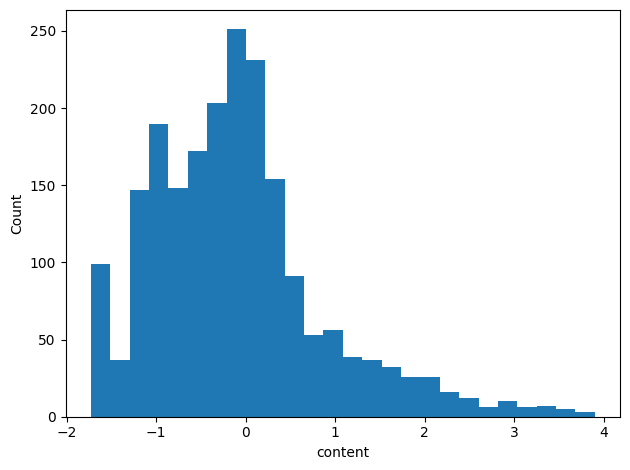

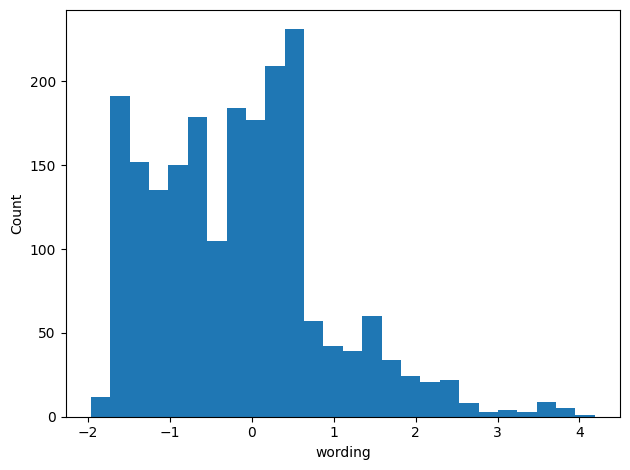

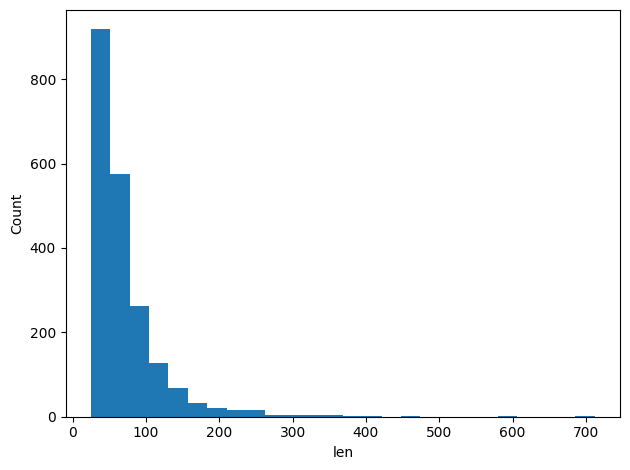

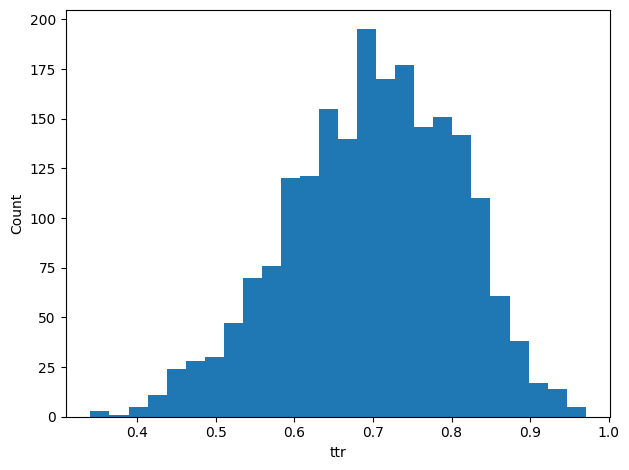

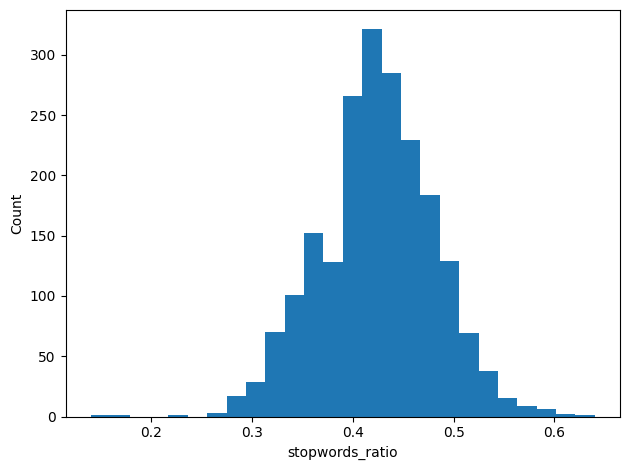

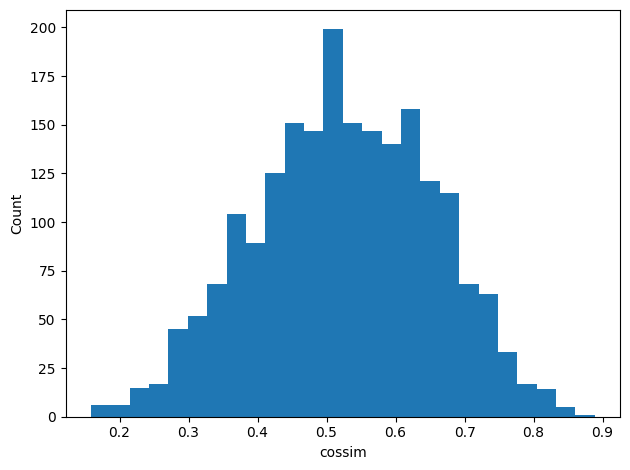

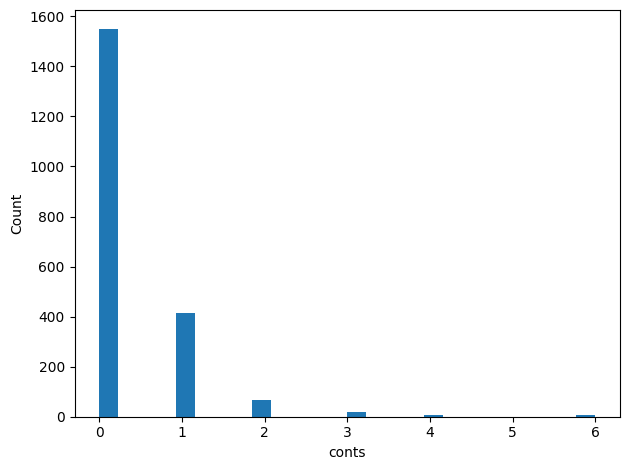

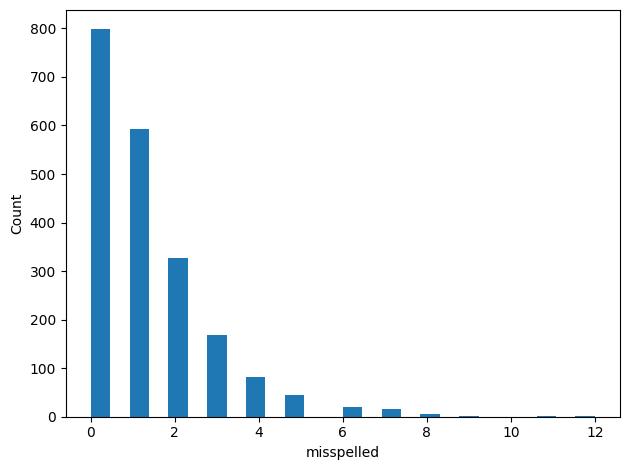

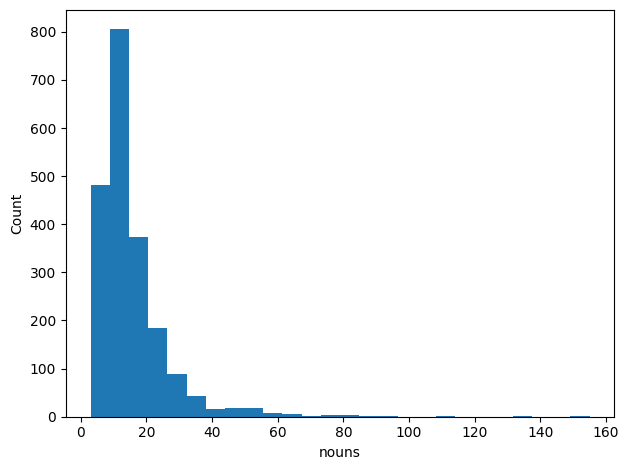

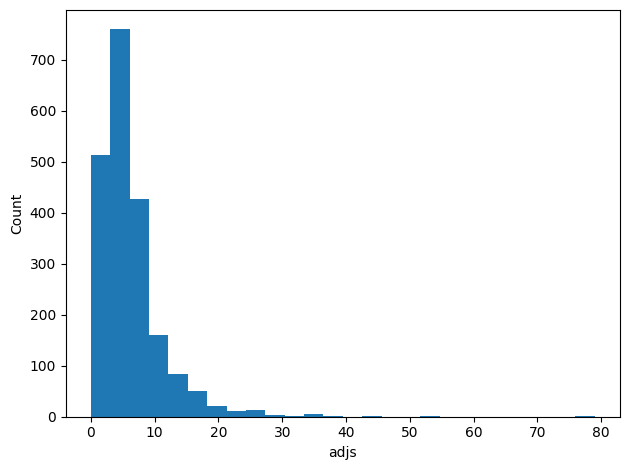

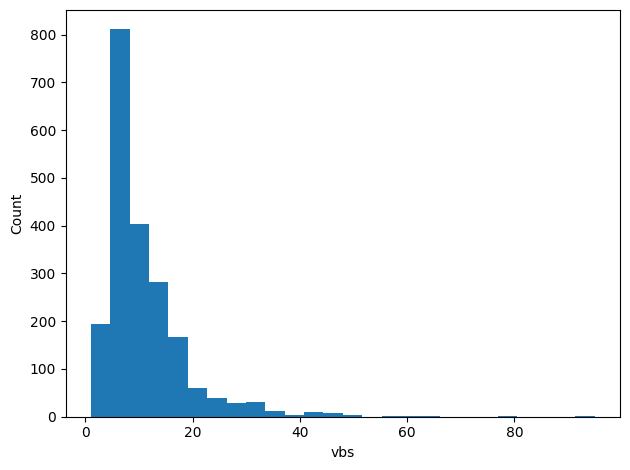

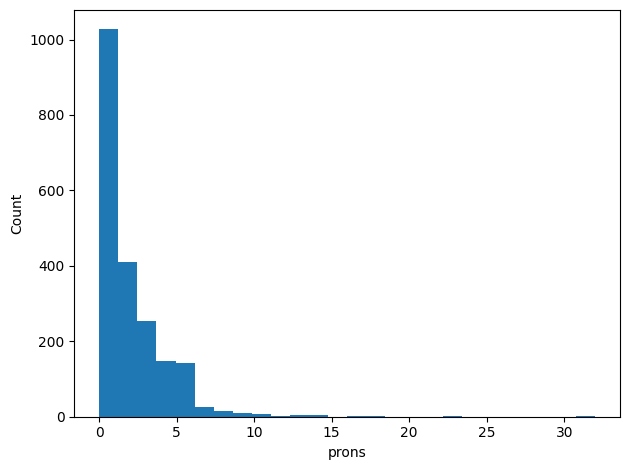

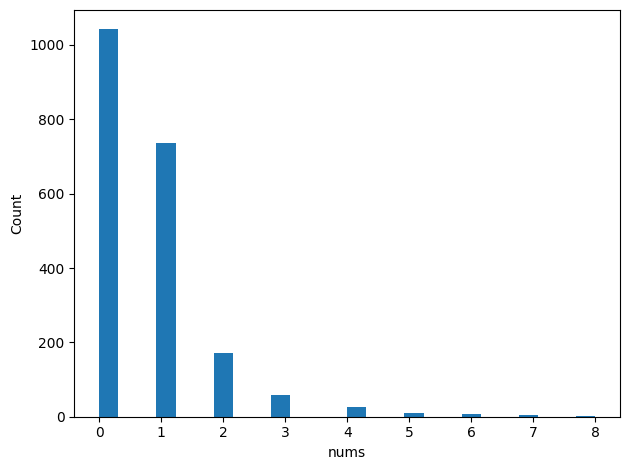

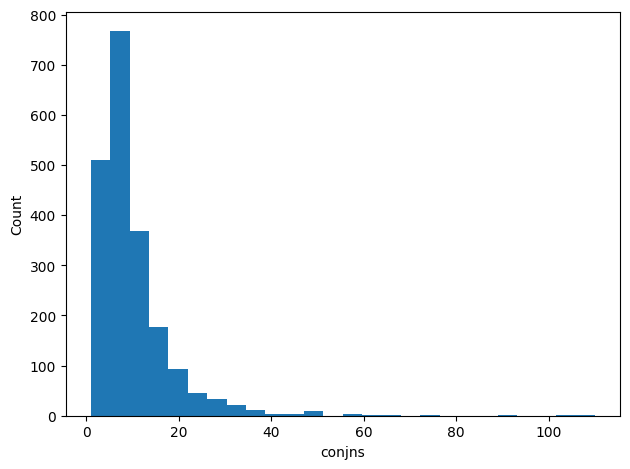

In [91]:

def plots(fea):
    fig, axs = plt.subplots(1,1, sharey=True, tight_layout=True)
    axs.hist(df_1[fea], bins = math.floor(2 * (len(df_1)**(1/3))) + 1)
    # axs.plot(df_1[fea])
    axs.set_xlabel(fea)
    axs.set_ylabel("Count")
    plt.show()
    
for i in cols:
    plots(i)

A lot of features are skewed towards the left-side. It wouldn't be advisable to bias towards higher values of those features, and 
hence it is necessary to scale them.

In [97]:
scale_cols = ['len','conts','misspelled','nouns','adjs','vbs','prons','nums','conjns']
df_1_scale_cols = df_1[scale_cols]
df_2_scale_cols = df_2[scale_cols]
df_3_scale_cols = df_3[scale_cols]
df_4_scale_cols = df_4[scale_cols]

scaler1 = StandardScaler()
sc_1_data = scaler1.fit_transform(df_1_scale_cols)
df_1[scale_cols] = sc_1_data

scaler2 = StandardScaler()
sc_2_data = scaler2.fit_transform(df_2_scale_cols)
df_2[scale_cols] = sc_2_data

scaler3 = StandardScaler()
sc_3_data = scaler3.fit_transform(df_3_scale_cols)
df_3[scale_cols] = sc_3_data

scaler4 = StandardScaler()
sc_4_data = scaler4.fit_transform(df_4_scale_cols)
df_4[scale_cols] = sc_4_data

### Model implementation

In [104]:
y_1 = df_1.loc[:,['content','wording']]
x_1 = df_1.drop(['content','wording'], axis = 1)
y_2 = df_2.loc[:,['content','wording']]
x_2 = df_2.drop(['content','wording'], axis = 1)
y_3 = df_3.loc[:,['content','wording']]
x_3 = df_3.drop(['content','wording'], axis = 1)
y_4 = df_4.loc[:,['content','wording']]
x_4 = df_4.drop(['content','wording'], axis = 1)

In [106]:
ESTIMATORS = {
    "Extra trees": ExtraTreesRegressor(n_estimators=10,),
    "K-nn": KNeighborsRegressor(),
    "Linear regression": LinearRegression(),
    "Ridge": RidgeCV(),
    "Lasso": Lasso(),
    "ElasticNet": ElasticNet(random_state=0),
    "RandomForestRegressor": RandomForestRegressor(max_depth=4, random_state=2),
    "Decision Tree Regressor":DecisionTreeRegressor(max_depth=5),
    "MultiO/P GBR" :MultiOutputRegressor(GradientBoostingRegressor(n_estimators=5)),
    "MultiO/P AdaB" :MultiOutputRegressor(AdaBoostRegressor(n_estimators=5))
}

In [109]:
def split(x,y):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)
    return x_train, x_test, y_train, y_test

x_1_train, x_1_test, y_1_train, y_1_test = split(x_1, y_1)
x_2_train, x_2_test, y_2_train, y_2_test = split(x_2, y_2)
x_3_train, x_3_test, y_3_train, y_3_test = split(x_3, y_3)
x_4_train, x_4_test, y_4_train, y_4_test = split(x_4, y_4)

In [111]:
def training(x_train, y_train, x_test, y_test):
    errors = {}
    for name, estimator in ESTIMATORS.items():
        estimator.fit(x_train, y_train)
        pred = estimator.predict(x_test)
        errors[name] = mean_squared_error(y_test, pred)
    return errors

xtrains = [x_1_train, x_2_train, x_3_train, x_4_train]
ytrains = [y_1_train, y_2_train, y_3_train, y_4_train]
xtests = [x_1_test, x_2_test, x_3_test, x_4_test]
ytests = [y_1_test, y_2_test, y_3_test, y_4_test]

ers = []
for xtrain,ytrain,xtest,ytest in zip(xtrains,ytrains,xtests,ytests):
    es = training(xtrain,ytrain,xtest,ytest)
    ers.append(es)

print(ers)

[{'Extra trees': 0.35342230851041223, 'K-nn': 0.42967580593006044, 'Linear regression': 0.4229461508359641, 'Ridge': 0.4234262346113013, 'Lasso': 1.024505148322825, 'ElasticNet': 0.7261830570891545, 'RandomForestRegressor': 0.33846830460685967, 'Decision Tree Regressor': 0.3691854893748694, 'MultiO/P GBR': 0.5808470278029672, 'MultiO/P AdaB': 0.3597979511081326}, {'Extra trees': 0.4235437157898022, 'K-nn': 0.4595198373885734, 'Linear regression': 0.4685415272723139, 'Ridge': 0.4684732370807688, 'Lasso': 0.9834196921315497, 'ElasticNet': 0.7453297705412131, 'RandomForestRegressor': 0.3843040372483375, 'Decision Tree Regressor': 0.4222295905708702, 'MultiO/P GBR': 0.5987568635367806, 'MultiO/P AdaB': 0.41073034155570476}, {'Extra trees': 0.38563483919547203, 'K-nn': 0.45661437688693296, 'Linear regression': 0.37550373055016417, 'Ridge': 0.37567985575200924, 'Lasso': 0.9255061850600804, 'ElasticNet': 0.7771538170137821, 'RandomForestRegressor': 0.3680797668963446, 'Decision Tree Regressor